## 6.12 Homework 6: Decision Trees and Ensemble Learning

### Dataset

In this homework, we will use the Students Performance in 2024 JAMB dataset from Kaggle:

    https://www.kaggle.com/datasets/idowuadamo/students-performance-in-2024-jamb

The goal of this homework is to create a regression model for predicting the performance of students on a standardized test (column 'JAMB_Score').

In [285]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from IPython.display import display
from io import StringIO

%matplotlib inline
%load_ext ipywidgets

The ipywidgets extension is already loaded. To reload it, use:
  %reload_ext ipywidgets


In [90]:
# Loading and previewing the dataset

data = 'jamb_exam_results.csv'
df = pd.read_csv(data)
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [92]:
df.shape

(5000, 17)

### Preparing the dataset

First, let's make the names lowercase:

    df.columns = df.columns.str.lower().str.replace(' ', '_')

Preparation:

- Remove the student_id column.
- Fill missing values with zeros.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.
- Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [95]:
# Making the column names lowercase

df.columns = df.columns.str.lower()
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,student_id,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [97]:
# Removing student id column

del df['student_id']
df.columns

Index(['jamb_score', 'study_hours_per_week', 'attendance_rate',
       'teacher_quality', 'distance_to_school', 'school_type',
       'school_location', 'extra_tutorials', 'access_to_learning_materials',
       'parent_involvement', 'it_knowledge', 'age', 'gender',
       'socioeconomic_status', 'parent_education_level',
       'assignments_completed'],
      dtype='object')

In [101]:
# Checking for missing values

df.isnull().sum()

jamb_score                        0
study_hours_per_week              0
attendance_rate                   0
teacher_quality                   0
distance_to_school                0
school_type                       0
school_location                   0
extra_tutorials                   0
access_to_learning_materials      0
parent_involvement                0
it_knowledge                      0
age                               0
gender                            0
socioeconomic_status              0
parent_education_level          891
assignments_completed             0
dtype: int64

In [103]:
# Checking for numerical data missing values

df.describe().round()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,age,assignments_completed
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,174.0,20.0,84.0,3.0,10.0,18.0,2.0
std,48.0,10.0,9.0,1.0,5.0,2.0,1.0
min,100.0,0.0,50.0,1.0,0.0,15.0,1.0
25%,135.0,13.0,78.0,2.0,7.0,16.0,1.0
50%,170.0,19.0,84.0,2.0,10.0,18.0,1.0
75%,209.0,26.0,91.0,3.0,13.0,20.0,2.0
max,367.0,40.0,100.0,5.0,20.0,22.0,5.0


In [105]:
# Checking 'parent_education_level' for unique values

df['parent_education_level'].unique()

array(['Tertiary', nan, 'Primary', 'Secondary'], dtype=object)

In [107]:
# Replacing missing values in 'parent_education_level' with 0

df['parent_education_level'] = df['parent_education_level'].fillna(0)
df.isnull().sum()

jamb_score                      0
study_hours_per_week            0
attendance_rate                 0
teacher_quality                 0
distance_to_school              0
school_type                     0
school_location                 0
extra_tutorials                 0
access_to_learning_materials    0
parent_involvement              0
it_knowledge                    0
age                             0
gender                          0
socioeconomic_status            0
parent_education_level          0
assignments_completed           0
dtype: int64

In [115]:
# Performing the train/validation/test split with 60%/20%/20% distribution and resetting the indices

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

len(df_train), len(df_val), len(df_test)

(3000, 1000, 1000)

In [117]:
# Separating and removing the target variable from the datasets

y_train = (df_train.jamb_score).astype('int').values
y_val = (df_val.jamb_score).astype('int').values
y_test = (df_test.jamb_score).astype('int').values
 
del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']
 
df_train

,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,20,72,3,4.4,Public,Urban,No,Yes,Medium,Low,21,Female,Low,0,3
1,11,80,2,3.3,Public,Urban,Yes,Yes,Medium,High,22,Female,Medium,Secondary,1
2,31,82,1,8.3,Public,Urban,Yes,Yes,Low,High,19,Female,High,Tertiary,2
3,29,79,1,15.8,Public,Rural,Yes,Yes,Low,Low,19,Male,Low,Primary,2
4,28,96,2,8.9,Private,Rural,Yes,Yes,Medium,Low,19,Male,High,Secondary,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1,79,3,12.2,Public,Urban,No,No,Low,High,17,Male,High,Secondary,1
2996,3,87,1,9.6,Public,Urban,No,No,Medium,Medium,17,Male,Medium,Primary,1
2997,17,96,4,13.7,Private,Urban,No,Yes,High,Medium,16,Male,Medium,Primary,2
2998,25,74,2,3.4,Public,Rural,No,No,High,High,21,Male,Low,Secondary,1


In [119]:
# Turning the dataframe into a list of dictionaries

train_dicts = df_train.fillna(0).to_dict(orient='records')
train_dicts[:5]

[{'study_hours_per_week': 20,
  'attendance_rate': 72,
  'teacher_quality': 3,
  'distance_to_school': 4.4,
  'school_type': 'Public',
  'school_location': 'Urban',
  'extra_tutorials': 'No',
  'access_to_learning_materials': 'Yes',
  'parent_involvement': 'Medium',
  'it_knowledge': 'Low',
  'age': 21,
  'gender': 'Female',
  'socioeconomic_status': 'Low',
  'parent_education_level': 0,
  'assignments_completed': 3},
 {'study_hours_per_week': 11,
  'attendance_rate': 80,
  'teacher_quality': 2,
  'distance_to_school': 3.3,
  'school_type': 'Public',
  'school_location': 'Urban',
  'extra_tutorials': 'Yes',
  'access_to_learning_materials': 'Yes',
  'parent_involvement': 'Medium',
  'it_knowledge': 'High',
  'age': 22,
  'gender': 'Female',
  'socioeconomic_status': 'Medium',
  'parent_education_level': 'Secondary',
  'assignments_completed': 1},
 {'study_hours_per_week': 31,
  'attendance_rate': 82,
  'teacher_quality': 1,
  'distance_to_school': 8.3,
  'school_type': 'Public',
  'sch

In [121]:
# Turning the list of dictionaries into a feature matrix

dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 45000 stored elements and shape (3000, 29)>

In [123]:
# Getting out the feature names of all numerical and encoded variables

dv.get_feature_names_out()

array(['access_to_learning_materials=No',
       'access_to_learning_materials=Yes', 'age', 'assignments_completed',
       'attendance_rate', 'distance_to_school', 'extra_tutorials=No',
       'extra_tutorials=Yes', 'gender=Female', 'gender=Male',
       'it_knowledge=High', 'it_knowledge=Low', 'it_knowledge=Medium',
       'parent_education_level', 'parent_education_level=Primary',
       'parent_education_level=Secondary',
       'parent_education_level=Tertiary', 'parent_involvement=High',
       'parent_involvement=Low', 'parent_involvement=Medium',
       'school_location=Rural', 'school_location=Urban',
       'school_type=Private', 'school_type=Public',
       'socioeconomic_status=High', 'socioeconomic_status=Low',
       'socioeconomic_status=Medium', 'study_hours_per_week',
       'teacher_quality'], dtype=object)

### Question 1

Let's train a decision tree regressor to predict the jamb_score variable.

- Train a model with max_depth=1.

Which feature is used for splitting the data?

- study_hours_per_week
- attendance_rate
- teacher_quality
- distance_to_school

In [129]:
# Training a Decision Tree Regressor with max_depth=1

dt = DecisionTreeRegressor(max_depth=1, random_state=0)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1, random_state=0)

In [148]:
# Extracting the feature used for splitting at the root node

root_feature_index = dt.tree_.feature[0]
feature_names = dv.get_feature_names_out()
feature_names[root_feature_index]

'study_hours_per_week'

#### Question 1 - Answer: study_hours_per_week

### Question 2

Train a random forest regressor with these parameters:

- n_estimators=10
- random_state=1
- n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on the validation data?

- 22.13
- 42.13
- 62.13
- 82.12

In [156]:
# Training a random forest regressor with specified parameters

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [166]:
# Transforming the validation dataset into numerical variables only

val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [173]:
# Predicting on the validation data
y_pred = rf.predict(X_val)

# Calculating RMSE
rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)),3)
print("RMSE:", rmse)

RMSE: 42.137


#### Question 2 - Answer: 42.13

### Question 3

Now let's experiment with the n_estimators parameter

- Try different values of this parameter from 10 to 200 with step 10.
- Set random_state to 1.
- Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for calculating the answer.

- 10
- 25
- 80
- 200

In [199]:
# List to store RMSE values for each n_estimators value
rmse_values = []

# Looping over n_estimators values from 10 to 200 with a step of 10
for n in range(10, 201, 10):
    # Training the RandomForestRegressor with the current value of n_estimators
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    # Predicting on the validation set
    y_pred = rf.predict(X_val)
    
    # Calculating RMSE
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_values.append((n, rmse))

# Output RMSE values for each n_estimators
for n, rmse in rmse_values:
    print(f"n_estimators={n}: RMSE={rmse:.3f}")

n_estimators=10: RMSE=42.137
n_estimators=20: RMSE=41.461
n_estimators=30: RMSE=41.106
n_estimators=40: RMSE=40.917
n_estimators=50: RMSE=40.852
n_estimators=60: RMSE=40.784
n_estimators=70: RMSE=40.677
n_estimators=80: RMSE=40.539
n_estimators=90: RMSE=40.504
n_estimators=100: RMSE=40.517
n_estimators=110: RMSE=40.593
n_estimators=120: RMSE=40.625
n_estimators=130: RMSE=40.651
n_estimators=140: RMSE=40.595
n_estimators=150: RMSE=40.597
n_estimators=160: RMSE=40.604
n_estimators=170: RMSE=40.628
n_estimators=180: RMSE=40.641
n_estimators=190: RMSE=40.631
n_estimators=200: RMSE=40.601


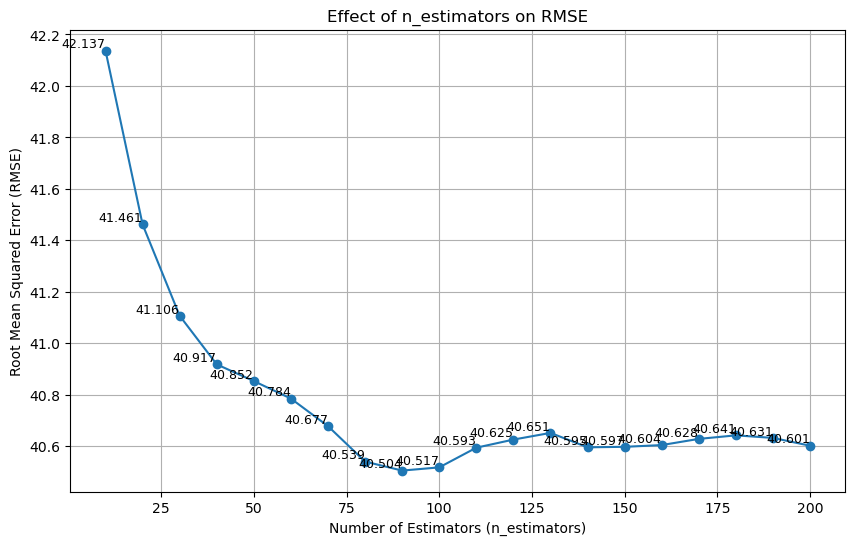

In [205]:
# Plotting n_estimators vs. RMSE with data point values displayed
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, rmse_scores, marker='o', label='RMSE')

# Annotating each point with its corresponding RMSE value
for i, (n, rmse) in enumerate(rmse_values):
    plt.text(n, rmse, f"{rmse:.3f}", ha='right', va='bottom', fontsize=9)

# Plotting n_estimators vs. RMSE
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Effect of n_estimators on RMSE')
plt.grid(True)
plt.show()

#### Question 3 - Answer: 80

### Question 4

Let's select the best max_depth:
- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values,
    - try different values of n_estimators from 10 till 200 (with step 10)
    - calculate the mean RMSE
- Fix the random seed: random_state=1

What's the best max_depth, using the mean RMSE?
- 10
- 15
- 20
- 25

In [217]:
# Defining the list of max_depth and n_estimators values to try
max_depth_values = [10, 15, 20, 25]
n_estimators_range = range(10, 201, 10)

# Dictionary to store the mean RMSE for each max_depth
mean_rmse_by_max_depth = {}

# Looping through each max_depth
for max_depth in max_depth_values:
    rmse_scores = []
    
    # Looping through each n_estimators value for the current max_depth
    for n in n_estimators_range:
        # Training the RandomForestRegressor with the specified max_depth and n_estimators
        rf = RandomForestRegressor(n_estimators=n, max_depth=max_depth, random_state=1, n_jobs=-1)
        
        # Calculating the cross-validated RMSE (negative mean squared error)
        # Using 5-fold cross-validation on the training data to get reliable mean RMSE
        scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        rmse = np.sqrt(-scores.mean())  # Converting from negative MSE to RMSE
        rmse_scores.append(rmse)
    
    # Storing the mean RMSE for the current max_depth
    mean_rmse_by_max_depth[max_depth] = np.mean(rmse_scores)

# Displaying the mean RMSE for each max_depth to identify the best one
mean_rmse_by_max_depth

{10: 40.091977463848785,
 15: 40.389821511739235,
 20: 40.4193862703798,
 25: 40.403408714364296}

#### Question 4 - Answer: 10

### Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:
- Train the model with these parameters:
    - n_estimators=10,
    - max_depth=20,
    - random_state=1,
    - n_jobs=-1 (optional)
- Get the feature importance information from this model

What's the most important feature (among these 4)?
- study_hours_per_week
- attendance_rate
- distance_to_school
- teacher_quality

In [224]:
# Training the RandomForestRegressor with specified parameters
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [226]:
# Extracting feature importances
feature_importances = rf.feature_importances_
feature_importances

array([0.0123254 , 0.01026189, 0.06931145, 0.03151679, 0.14972903,
       0.1364858 , 0.01345934, 0.00913136, 0.00928871, 0.01038263,
       0.01771934, 0.01240405, 0.00914148, 0.        , 0.01545036,
       0.01695692, 0.01448862, 0.02291885, 0.01335761, 0.01149201,
       0.00955909, 0.00923932, 0.0089532 , 0.00840598, 0.02571426,
       0.01070798, 0.01056268, 0.24835361, 0.08268222])

In [230]:
# Creating a DataFrame for better readability of feature importances
importances_df = pd.DataFrame({
    'Feature': dv.get_feature_names_out(),
    'Importance': feature_importances
})
importances_df

,Feature,Importance
0,access_to_learning_materials=No,0.012325
1,access_to_learning_materials=Yes,0.010262
2,age,0.069311
3,assignments_completed,0.031517
4,attendance_rate,0.149729
5,distance_to_school,0.136486
6,extra_tutorials=No,0.013459
7,extra_tutorials=Yes,0.009131
8,gender=Female,0.009289
9,gender=Male,0.010383


In [244]:
# Filtering for the specified features to identify the most important one
specified_features = ['study_hours_per_week', 'attendance_rate', 'distance_to_school', 'teacher_quality']
important_features_df = importances_df[importances_df['Feature'].isin(specified_features)]

In [250]:
# Sorting by importance and displaying the result
important_features_df = important_features_df.sort_values(by='Importance', ascending=False)
most_important_feature = important_features_df.iloc[0]
print(most_important_feature)

Feature       study_hours_per_week
Importance                0.248354
Name: 27, dtype: object


#### Question 5 - Answer: study_hours_per_week

### Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

    xgb_params = {
        'eta': 0.3, 
        'max_depth': 6,
        'min_child_weight': 1,
        
        'objective': 'reg:squarederror',
        'nthread': 8,
        
        'seed': 1,
        'verbosity': 1,
    }

Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?
- 0.3
- 0.1
- Both give equal value

In [419]:
# Creating DMatrix for training and validation dataset

features = dv.get_feature_names_out().tolist()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [421]:
# Creating a watchlist of datasets for evaluation and monitoring the performance of the training process

watchlist = [(dtrain, 'train'), (dval, 'val')]

In [423]:
# Defining the parameters for xgboost with the default parameters
# eta = 0.3

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [425]:
# Training the xgboost model for 100 rounds
# eta = 0.3

xgb_model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=100, evals=watchlist)

[0]	train-rmse:42.69384	val-rmse:44.89114
[1]	train-rmse:39.83326	val-rmse:43.07010
[2]	train-rmse:37.94542	val-rmse:42.00332
[3]	train-rmse:36.56125	val-rmse:41.46452
[4]	train-rmse:35.44252	val-rmse:40.88896
[5]	train-rmse:34.57756	val-rmse:40.69096
[6]	train-rmse:33.84230	val-rmse:40.59315
[7]	train-rmse:33.25929	val-rmse:40.47993
[8]	train-rmse:32.79415	val-rmse:40.45326
[9]	train-rmse:32.16019	val-rmse:40.43929
[10]	train-rmse:31.63404	val-rmse:40.48319
[11]	train-rmse:31.17673	val-rmse:40.68201
[12]	train-rmse:30.87313	val-rmse:40.63522
[13]	train-rmse:30.30310	val-rmse:40.70983
[14]	train-rmse:30.00098	val-rmse:40.78133
[15]	train-rmse:29.41497	val-rmse:40.86107
[16]	train-rmse:29.25816	val-rmse:40.96580
[17]	train-rmse:28.59378	val-rmse:41.12190
[18]	train-rmse:28.27990	val-rmse:41.14360
[19]	train-rmse:27.94572	val-rmse:41.22835
[20]	train-rmse:27.49658	val-rmse:41.27921
[21]	train-rmse:27.25449	val-rmse:41.32427
[22]	train-rmse:27.06652	val-rmse:41.41887
[23]	train-rmse:26.78

In [427]:
# Defining the parameters for xgboost with the default parameters
# eta = 0.1

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [429]:
# Training the xgboost model for 100 rounds
# eta = 0.1

xgb_model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=100, evals=watchlist)

[0]	train-rmse:45.49999	val-rmse:47.00533
[1]	train-rmse:44.12948	val-rmse:45.92344
[2]	train-rmse:42.94858	val-rmse:44.98366
[3]	train-rmse:41.90896	val-rmse:44.25755
[4]	train-rmse:40.96728	val-rmse:43.57339
[5]	train-rmse:40.17514	val-rmse:43.11181
[6]	train-rmse:39.40436	val-rmse:42.61054
[7]	train-rmse:38.71199	val-rmse:42.18883
[8]	train-rmse:38.08081	val-rmse:41.86754
[9]	train-rmse:37.57559	val-rmse:41.64338
[10]	train-rmse:37.07490	val-rmse:41.39235
[11]	train-rmse:36.58709	val-rmse:41.14265
[12]	train-rmse:36.14574	val-rmse:40.95201
[13]	train-rmse:35.76896	val-rmse:40.81778
[14]	train-rmse:35.40802	val-rmse:40.75008
[15]	train-rmse:35.08521	val-rmse:40.61341
[16]	train-rmse:34.74187	val-rmse:40.51800
[17]	train-rmse:34.43969	val-rmse:40.41659
[18]	train-rmse:34.16132	val-rmse:40.33546
[19]	train-rmse:33.91836	val-rmse:40.25632
[20]	train-rmse:33.67389	val-rmse:40.25010
[21]	train-rmse:33.45853	val-rmse:40.19826
[22]	train-rmse:33.23371	val-rmse:40.21101
[23]	train-rmse:32.98

In [431]:
# Accessing the xgboost's monitoring output
# eta = 0.3

In [433]:
%%capture capture_output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]


xgb_model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=100, evals=watchlist)

s = capture_output.stdout

In [435]:
print(s)

[0]	train-rmse:42.69384	val-rmse:44.89114
[1]	train-rmse:39.83326	val-rmse:43.07010
[2]	train-rmse:37.94542	val-rmse:42.00332
[3]	train-rmse:36.56125	val-rmse:41.46452
[4]	train-rmse:35.44252	val-rmse:40.88896
[5]	train-rmse:34.57756	val-rmse:40.69096
[6]	train-rmse:33.84230	val-rmse:40.59315
[7]	train-rmse:33.25929	val-rmse:40.47993
[8]	train-rmse:32.79415	val-rmse:40.45326
[9]	train-rmse:32.16019	val-rmse:40.43929
[10]	train-rmse:31.63404	val-rmse:40.48319
[11]	train-rmse:31.17673	val-rmse:40.68201
[12]	train-rmse:30.87313	val-rmse:40.63522
[13]	train-rmse:30.30310	val-rmse:40.70983
[14]	train-rmse:30.00098	val-rmse:40.78133
[15]	train-rmse:29.41497	val-rmse:40.86107
[16]	train-rmse:29.25816	val-rmse:40.96580
[17]	train-rmse:28.59378	val-rmse:41.12190
[18]	train-rmse:28.27990	val-rmse:41.14360
[19]	train-rmse:27.94572	val-rmse:41.22835
[20]	train-rmse:27.49658	val-rmse:41.27921
[21]	train-rmse:27.25449	val-rmse:41.32427
[22]	train-rmse:27.06652	val-rmse:41.41887
[23]	train-rmse:26.78

In [437]:
# Accessing the xgboost's monitoring output
# eta = 0.1

In [443]:
%%capture capture_output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]


xgb_model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=100, evals=watchlist)

s = capture_output.stdout

In [445]:
print(s)

[0]	train-rmse:45.49999	val-rmse:47.00533
[1]	train-rmse:44.12948	val-rmse:45.92344
[2]	train-rmse:42.94858	val-rmse:44.98366
[3]	train-rmse:41.90896	val-rmse:44.25755
[4]	train-rmse:40.96728	val-rmse:43.57339
[5]	train-rmse:40.17514	val-rmse:43.11181
[6]	train-rmse:39.40436	val-rmse:42.61054
[7]	train-rmse:38.71199	val-rmse:42.18883
[8]	train-rmse:38.08081	val-rmse:41.86754
[9]	train-rmse:37.57559	val-rmse:41.64338
[10]	train-rmse:37.07490	val-rmse:41.39235
[11]	train-rmse:36.58709	val-rmse:41.14265
[12]	train-rmse:36.14574	val-rmse:40.95201
[13]	train-rmse:35.76896	val-rmse:40.81778
[14]	train-rmse:35.40802	val-rmse:40.75008
[15]	train-rmse:35.08521	val-rmse:40.61341
[16]	train-rmse:34.74187	val-rmse:40.51800
[17]	train-rmse:34.43969	val-rmse:40.41659
[18]	train-rmse:34.16132	val-rmse:40.33546
[19]	train-rmse:33.91836	val-rmse:40.25632
[20]	train-rmse:33.67389	val-rmse:40.25010
[21]	train-rmse:33.45853	val-rmse:40.19826
[22]	train-rmse:33.23371	val-rmse:40.21101
[23]	train-rmse:32.98

In [447]:
s.split('\n')

['[0]\ttrain-rmse:45.49999\tval-rmse:47.00533',
 '[1]\ttrain-rmse:44.12948\tval-rmse:45.92344',
 '[2]\ttrain-rmse:42.94858\tval-rmse:44.98366',
 '[3]\ttrain-rmse:41.90896\tval-rmse:44.25755',
 '[4]\ttrain-rmse:40.96728\tval-rmse:43.57339',
 '[5]\ttrain-rmse:40.17514\tval-rmse:43.11181',
 '[6]\ttrain-rmse:39.40436\tval-rmse:42.61054',
 '[7]\ttrain-rmse:38.71199\tval-rmse:42.18883',
 '[8]\ttrain-rmse:38.08081\tval-rmse:41.86754',
 '[9]\ttrain-rmse:37.57559\tval-rmse:41.64338',
 '[10]\ttrain-rmse:37.07490\tval-rmse:41.39235',
 '[11]\ttrain-rmse:36.58709\tval-rmse:41.14265',
 '[12]\ttrain-rmse:36.14574\tval-rmse:40.95201',
 '[13]\ttrain-rmse:35.76896\tval-rmse:40.81778',
 '[14]\ttrain-rmse:35.40802\tval-rmse:40.75008',
 '[15]\ttrain-rmse:35.08521\tval-rmse:40.61341',
 '[16]\ttrain-rmse:34.74187\tval-rmse:40.51800',
 '[17]\ttrain-rmse:34.43969\tval-rmse:40.41659',
 '[18]\ttrain-rmse:34.16132\tval-rmse:40.33546',
 '[19]\ttrain-rmse:33.91836\tval-rmse:40.25632',
 '[20]\ttrain-rmse:33.67389\tv

In [449]:
line = s.split('\n')[0]
line

'[0]\ttrain-rmse:45.49999\tval-rmse:47.00533'

In [451]:
line.split('\t')

['[0]', 'train-rmse:45.49999', 'val-rmse:47.00533']

In [453]:
num_iter, train_rmse, val_rmse = line.split('\t')
num_iter, train_rmse, val_rmse

('[0]', 'train-rmse:45.49999', 'val-rmse:47.00533')

In [455]:
int(num_iter.strip('[]'))

0

In [457]:
float(train_rmse.split(':')[1])

45.49999

In [459]:
float(val_rmse.split(':')[1])

47.00533

In [461]:
# Parsing xgboost’s monitoring output as a dataframe

def parse_xgb_output(output):
    results = []
 
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
 
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
 
        results.append((it, train, val))
     
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [463]:
df_score = parse_xgb_output(capture_output)
df_score

,num_iter,train_rmse,val_rmse
0,0,45.49999,47.00533
1,1,44.12948,45.92344
2,2,42.94858,44.98366
3,3,41.90896,44.25755
4,4,40.96728,43.57339
...,...,...,...
95,95,24.03404,40.99952
96,96,24.00230,41.00887
97,97,23.88940,41.05015
98,98,23.76232,41.06328


In [465]:
# Tuning Eta (=learning rate or correction rate)
# Evaluating the different models at different etas

scores = {}

In [469]:
%%capture output
 
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
 
xgb_model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=100, evals=watchlist)

In [471]:
# Checking the RMSE for eta = 0.3

'eta=%s' % (xgb_params['eta'])

'eta=0.3'

In [473]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.3'

In [475]:
scores

{'eta=0.3':     num_iter  train_rmse  val_rmse
 0          0    42.69384  44.89114
 1          1    39.83326  43.07010
 2          2    37.94542  42.00332
 3          3    36.56125  41.46452
 4          4    35.44252  40.88896
 ..       ...         ...       ...
 95        95    11.95568  43.37919
 96        96    11.76819  43.39410
 97        97    11.58218  43.40203
 98        98    11.53812  43.40245
 99        99    11.39140  43.41882
 
 [100 rows x 3 columns]}

In [477]:
scores['eta=0.3']

,num_iter,train_rmse,val_rmse
0,0,42.69384,44.89114
1,1,39.83326,43.07010
2,2,37.94542,42.00332
3,3,36.56125,41.46452
4,4,35.44252,40.88896
...,...,...,...
95,95,11.95568,43.37919
96,96,11.76819,43.39410
97,97,11.58218,43.40203
98,98,11.53812,43.40245


In [479]:
%%capture output
 
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
 
xgb_model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=100, evals=watchlist)

In [481]:
# Checking the RMSE for eta = 0.1

key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

In [483]:
scores['eta=0.1']

,num_iter,train_rmse,val_rmse
0,0,45.49999,47.00533
1,1,44.12948,45.92344
2,2,42.94858,44.98366
3,3,41.90896,44.25755
4,4,40.96728,43.57339
...,...,...,...
95,95,24.03404,40.99952
96,96,24.00230,41.00887
97,97,23.88940,41.05015
98,98,23.76232,41.06328


In [485]:
# Plotting all different eta

scores.keys()

dict_keys(['eta=0.3', 'eta=0.1'])

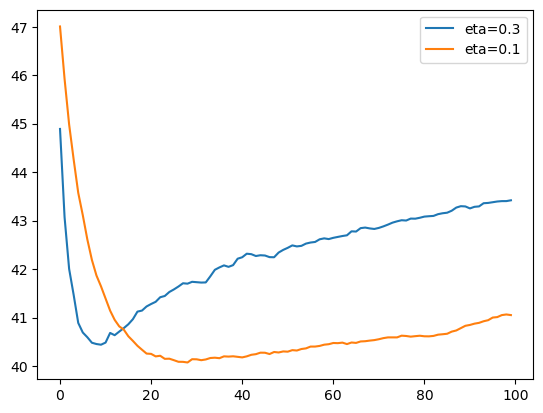

In [487]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=key)
plt.legend()

#### Question 6 - Answer: 0.1